In [3]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image
import cv2
import numpy as np
import pandas as pd
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [4]:
from pathlib import Path
import os
import pandas as pd

# Define the data directory
data_dir = Path(r"D:\Dataset_BUSI_with_GT")

filepaths = []
labels = []

# Generate data paths with labels
folds = os.listdir(data_dir)
for fold in folds:
    foldpath = data_dir / fold  # Use Path for directory
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = foldpath / file  # Use Path for file paths
        filepaths.append(str(fpath))  # Convert Path object to string
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)

# Display the dataframe
print(df.head())


                                           filepaths  labels
0      D:\Dataset_BUSI_with_GT\benign\benign (1).png  benign
1  D:\Dataset_BUSI_with_GT\benign\benign (1)_mask...  benign
2     D:\Dataset_BUSI_with_GT\benign\benign (10).png  benign
3  D:\Dataset_BUSI_with_GT\benign\benign (10)_mas...  benign
4    D:\Dataset_BUSI_with_GT\benign\benign (100).png  benign


In [5]:
df

,filepaths,labels
0,D:\Dataset_BUSI_with_GT\benign\benign (1).png,benign
1,D:\Dataset_BUSI_with_GT\benign\benign (1)_mask...,benign
2,D:\Dataset_BUSI_with_GT\benign\benign (10).png,benign
3,D:\Dataset_BUSI_with_GT\benign\benign (10)_mas...,benign
4,D:\Dataset_BUSI_with_GT\benign\benign (100).png,benign
...,...,...
1573,D:\Dataset_BUSI_with_GT\normal\normal (97)_mas...,normal
1574,D:\Dataset_BUSI_with_GT\normal\normal (98).png,normal
1575,D:\Dataset_BUSI_with_GT\normal\normal (98)_mas...,normal
1576,D:\Dataset_BUSI_with_GT\normal\normal (99).png,normal


In [6]:
strat = df['labels']
train_df, test_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

In [7]:
test_df

,filepaths,labels
1445,D:\Dataset_BUSI_with_GT\normal\normal (39)_mas...,normal
215,D:\Dataset_BUSI_with_GT\benign\benign (194)_ma...,benign
106,D:\Dataset_BUSI_with_GT\benign\benign (146)_ma...,benign
339,D:\Dataset_BUSI_with_GT\benign\benign (249)_ma...,benign
305,D:\Dataset_BUSI_with_GT\benign\benign (233)_ma...,benign
...,...,...
1178,D:\Dataset_BUSI_with_GT\malignant\malignant (3...,malignant
1147,D:\Dataset_BUSI_with_GT\malignant\malignant (2...,malignant
460,D:\Dataset_BUSI_with_GT\benign\benign (302)_ma...,benign
1530,D:\Dataset_BUSI_with_GT\normal\normal (78).png,normal


In [8]:
# crobed image size
batch_size = 8
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 1262 validated image filenames belonging to 3 classes.
Found 316 validated image filenames belonging to 3 classes.


In [9]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", 
                                                               input_shape= img_shape, pooling= 'max')


model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])


model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])



43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 48s 1us/step


In [10]:
epochs = 50   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= test_gen, 
                    validation_steps= None, shuffle= False)

Epoch 1/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 550s 3s/step - accuracy: 0.5975 - loss: 11.3299 - val_accuracy: 0.7437 - val_loss: 7.3563
Epoch 2/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 407s 3s/step - accuracy: 0.6152 - loss: 6.7392 - val_accuracy: 0.7595 - val_loss: 5.9137
Epoch 3/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 418s 3s/step - accuracy: 0.7029 - loss: 5.6743 - val_accuracy: 0.7690 - val_loss: 4.9838
Epoch 4/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 432s 3s/step - accuracy: 0.7339 - loss: 4.7980 - val_accuracy: 0.7690 - val_loss: 4.1970
Epoch 5/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 395s 2s/step - accuracy: 0.7482 - loss: 4.0571 - val_accuracy: 0.7816 - val_loss: 3.5179
Epoch 6/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 356s 2s/step - accuracy: 0.8020 - loss: 3.4114 - val_accuracy: 0.8228 - val_loss: 2.9291
Epoch 7/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 355s 2s/step - accuracy: 0.8201 - loss: 2.8431 - val_accuracy: 0.8291 - val_loss: 2.4350
Epoch 8/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 364s 2s/step - accuracy: 0.8090 - loss: 2.3951 - val_acc

In [11]:
train_score = model.evaluate(train_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

158/158 ━━━━━━━━━━━━━━━━━━━━ 69s 435ms/step - accuracy: 0.9987 - loss: 0.2094
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 464ms/step - accuracy: 0.9685 - loss: 0.2987
Train Loss:  0.21072281897068024
Train Accuracy:  0.999207615852356
--------------------
Test Loss:  0.35125496983528137
Test Accuracy:  0.949367105960846


In [12]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

40/40 ━━━━━━━━━━━━━━━━━━━━ 28s 555ms/step


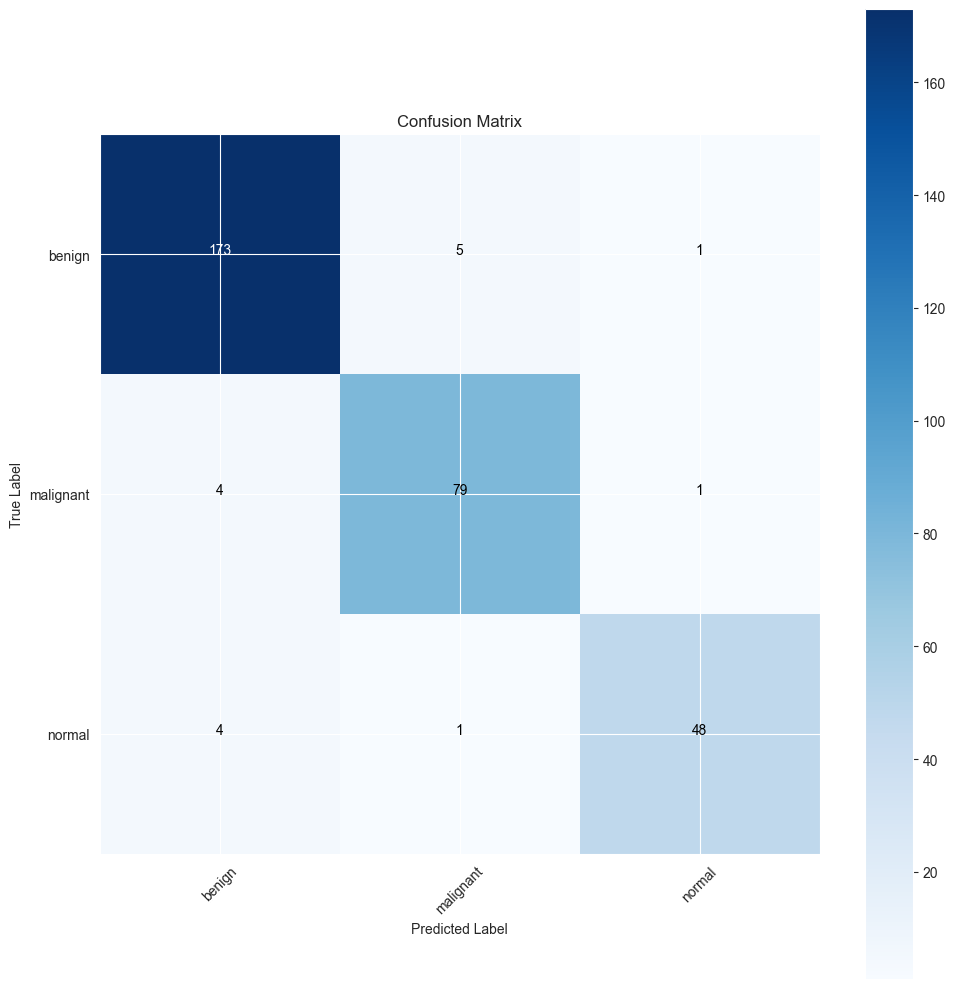

In [13]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [14]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      benign       0.96      0.97      0.96       179
   malignant       0.93      0.94      0.93        84
      normal       0.96      0.91      0.93        53

    accuracy                           0.95       316
   macro avg       0.95      0.94      0.94       316
weighted avg       0.95      0.95      0.95       316



In [15]:
#Save the model
model.save('Model.h5')